<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab3_MW/blob/main/Lab3_MW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab 3  Mechanical Waves

Evgeny Kolonsky 2024

v.0.1.6

In [1]:
import numpy as np
from scipy import linalg as LA
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

https://lpsa.swarthmore.edu/MtrxVibe/MatrixAll.html

https://cooperrc.github.io/computational-mechanics/module_05/03_Good_Vibrations.html#./02_Keep_it_steady.ipynb


Motion equataion for a system without energy losses in matrix form is
$$
M \ddot x + K x = F
$$
here $M$ - moment inertia matrix, $F$ - angle elastity matrix, $F$ -  external force moments vector, $x$ - coordinates (rotation angles) vector.

Boundary conditions

The left end is drived by external driver
$$
x_0(t) = \eta(t)
$$

Coordinates vector $x$
$$
x =  \begin{bmatrix}
      x_1 \\
      \vdots\\
      x_n \end{bmatrix} ,
$$

Inertia matrix $M$
$$
M =  \begin{bmatrix}
      J_1 &     \\
       &\ddots & \\
       &            & J_n
      \end{bmatrix} ,
$$
Elastity matrix $K$
$$
K =  \begin{bmatrix}
      2 k &  -k  &  &         \\
      -k  &  2k  & -k &          \\
         & -k   & 2k  & -k &         \\
      & & &\ddots & -k\\
      & &         & -k & 2 k
      \end{bmatrix}
$$


If $E_i$ is eigenvectors  and $\lambda_i$  is eigenvalue of matrix $Z = M^{-1}  K$, then natural frequecnies are
$$
\omega_i = \sqrt\lambda_i \quad i = 1,\cdots, n.
$$

Set up new **state variable** $z$:

$$
z =  [ x_1, \cdots x_n, \, \dot x_1, \cdots, \dot x_n ] = [x, \dot x]
$$
it's derivative
$$
\dot z =  [ \dot x, \ddot x ] ,
$$
and state equation
$$
\dot z =
\begin{bmatrix}
\dot x\\
\ddot x
\end{bmatrix}
 =
\begin{bmatrix}
0 & I\\
-M^{-1}K & 0
\end{bmatrix}
\begin{bmatrix}
x\\
\dot x
\end{bmatrix}
$$
Here $I$ - identity matrix.

The state equation with viscous friction and external force $F$ will be
$$
\dot z =
\begin{bmatrix}
0 & I\\
-M^{-1}K & -M^{-1}B
\end{bmatrix}
z
+
\begin{bmatrix}
0 \\
M^{-1} F
\end{bmatrix}
,
$$
where diagonal elements of $B$ are respective friction coefficients
$$
B =  \begin{bmatrix}
      b_1 &     \\
       &\ddots & \\
       &            & b_n
      \end{bmatrix} ,
$$
in motion differential equation
$$
M \ddot x  + B \dot x + K x = F
$$


Constants and parameters

In [3]:
# System parameters
l = 456e-3  # length of bar
m = 42e-3   # mass of bar
J = m * l**2 / 12 # moment of inertia of bar

# the mechanical wave system
L = 920e-3 # length of the system
n = 72 # number of elements in rotational oscillations system
d = L / (n -1) # distance between bars

k = 1.02 # elastity coeff
Q = 80 # quality factor
b =  np.sqrt(J*k) / Q # approx. friction coefficent (at least by order value)

v = d * np.sqrt(k/J)
print(f'wave velocity expected {v*100:.0f} cm/s')

# external force
eta0 = 0.03 # external elastic displacement
order = 2
freq_external = order * v /  4 / L # hz
omega_external = 2* np.pi *  freq_external # rad/s
acceleration_external =  eta0 * k / J
print(f'external force frequency {freq_external:.2f} Hz')

wave velocity expected 49 cm/s
external force frequency 0.26 Hz


In [4]:
K = k * np.diag(np.ones(n) * 2, 0) + \
    np.diag(-np.ones(n-1)   , 1) +  \
    np.diag(-np.ones(n-1)   ,-1)

M = np.eye(n) * J

B = np.eye(n) * b

F = np.zeros(n)
F[0] = acceleration_external # applied only at leftmost point


zeros = np.zeros((n,n))
I     = np.eye(n)
Km    =  LA.inv(M) @ K
Bm    =  LA.inv(M) @ B

D = np.vstack([np.hstack([zeros,  I]),
               np.hstack([-Km,   -Bm])] \
             )
F2 = np.hstack([np.zeros(n), \
                F])

def state_derivative(state, time):
  # state - array of x1 .. xn, v1.. vn
  # x - coordinates and v - corresponding velocities
  # ti - point of time. External force depends on time
  zdot = D @ state
  zdot += F2 * np.sin(2 * np.pi * omega_external * time)
  return zdot

def heun_step(state, time, dt,etol=0.000001,maxiters = 100):
    '''Update a state to the next time increment using the implicit Heun's method.

    Arguments
    ---------
    state : array of dependent variables
    dt    : float, time increment
    etol  : tolerance in error for each time step corrector
    maxiters: maximum number of iterations each time step can take

    Returns
    -------
    next_state : array, updated after one time increment'''
    e=1
    eps=np.finfo('float64').eps
    next_state = state + state_derivative(state, time) * dt
    ################### New iterative correction #########################
    for n in range(0,maxiters):
        next_state_old = next_state
        next_state = state + (state_derivative(state, time) + state_derivative(next_state, time))/2*dt
        e = np.sum(np.abs(next_state-next_state_old)/np.abs(next_state+eps))
        if e < etol:
            break
    ############### end of iterative correction #########################
    return next_state


In [5]:
lambdas, E = LA.eig(Km)
omega = np.sqrt(lambdas)

freqs = np.real(omega) / 2 / np.pi

print(f'Natural frequencies from {np.min(freqs):.2f} Hz to {np.max(freqs):.2f} Hz')

Natural frequencies from 1.21 Hz to 11.86 Hz


Integrate numerically, with small time increments  

In [6]:
T = 8 * L / v # time to travel there and back again twice
dt = 1 / np.max(freqs) / 4 # shortest period / 4

t = np.arange(0, T, dt)
N = len(t)  # steps in time


# initial state


# half-wave on the left end
cos_wave = np.zeros(n)
n1 = int(n /6)
#for i in range(n1):
#  cos_wave[i] = np.cos(np.pi *i / 2 /n1 )

# symmetric half-wave on the right end
#for i in range(n1):
#  cos_wave[-i] = np.cos(np.pi *i / 2 /n1 )




state = np.zeros((2 * n, N))
state[:n, 0] = 0.1 * cos_wave  # set initial condition

for i in range(0, N-1):
    state[:,i+1] = heun_step(state[:,i], t[i], dt)

Animate

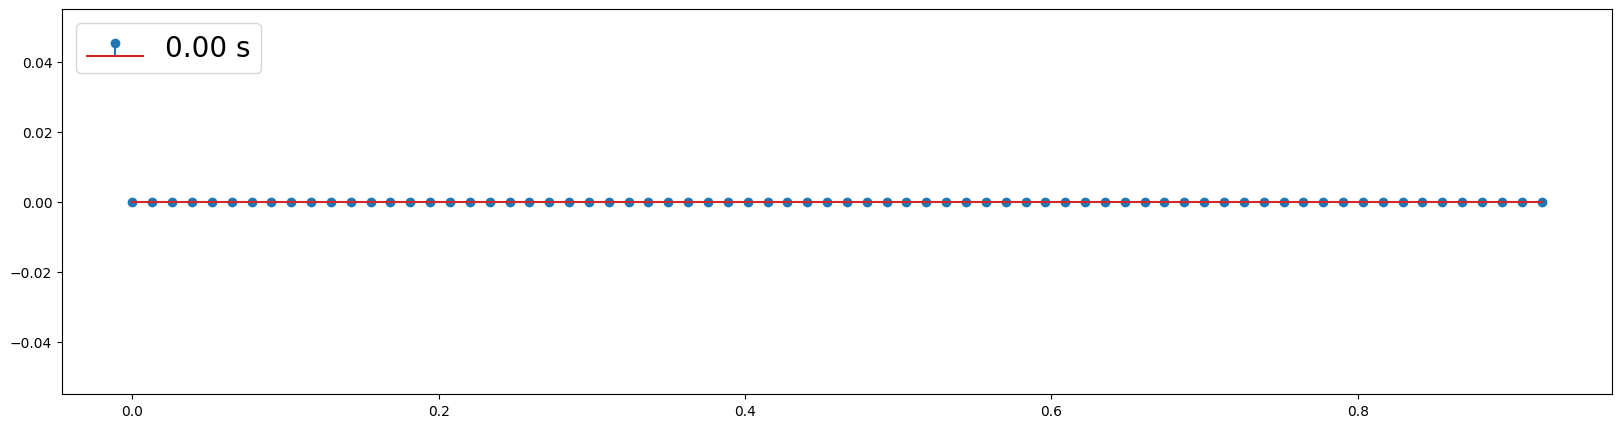

In [7]:
fig, ax = plt.subplots(figsize=(20, 5))
x = np.linspace(0, L, n)
y = np.copy(state[:n, 0])
y[0] = np.max(np.abs(y))
y[-1] = -y[0]
bottom = 0
h_stem = ax.stem(x, y, bottom=bottom,  linefmt='-', markerfmt='o', label='Time');
legend = ax.legend(fontsize="20", loc ="upper left") #Define legend objects

def update(i):
    y = state[:n, i]

    # markerline
    h_stem[0].set_ydata(y)
    h_stem[0].set_xdata(x)  # not necessary for constant x

    # stemlines
    h_stem[1].set_paths([np.array([[xx, bottom],
                                   [xx, yy]]) for (xx, yy) in zip(x, y)])

    # baseline
    h_stem[2].set_xdata([np.min(x), np.max(x)])
    h_stem[2].set_ydata([bottom, bottom])  # not necessary for constant bottom
    legend.get_texts()[0].set_text(f'{t[i]:.2f} s') #Update label each at frame

anim = FuncAnimation(fig, update, frames=range(0,N,2), interval=2*dt)
anim.save('so.gif', dpi=80)